In [1]:
%matplotlib inline

# 鑑黃大師

ˊ![md_images](../Images/porndetector.jpg?raw=true)

![md_images](../Images/pornclass.jpg?raw=true)

In [2]:
# im = cv2.imread(imgpath)
# rr = random.randint(0, 10)
# if rr % 3 == 0:
#     im = cv2.resize(im, (64, 64), interpolation=cv2.INTER_AREA)
# elif rr % 3 == 1:
#     scale = 64 / max(im.shape[:2])
#     im_org = cv2.resize(im, (int(im.shape[1] * scale), int(im.shape[0] * scale)), interpolation=cv2.INTER_AREA)
#     im = np.ones((64, 64, 3), dtype=np.float32) * 255
#     im[:im_org.shape[0], :im_org.shape[1], :] = im_org
# elif rr % 3 == 2:
#     scale = 64 / min(im.shape[:2])
#     im_org = cv2.resize(im, (int(im.shape[1] * scale), int(im.shape[0] * scale)), interpolation=cv2.INTER_AREA)
#     offset_x = 0
#     if im_org.shape[1] > 64:
#         offset_x = random.choice(range(0, im_org.shape[1] - 64))
#     offset_y = 0
#     if im_org.shape[0] > 64:
#         offset_y = random.choice(range(0, im_org.shape[0] - 64))
#     im = im_org[offset_y:offset_y + 64 , offset_x:offset_x + 64 , :]

In [3]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import math
import random
import glob
import pickle
import PIL
from PIL import Image

from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential,Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras import metrics

Using TensorFlow backend.


10001
5746
(10001, 64, 64, 3)
(10001, 5)


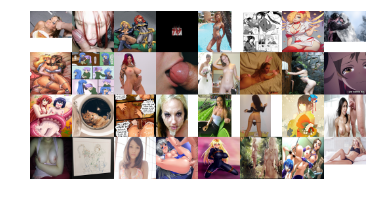

In [4]:
f1 = open('../Data/train_porn_detector64_small.pkl', 'rb')
trainData=pickle.load(f1)  
f2 = open('../Data/test_porn_detector64_small.pkl', 'rb')
testData=pickle.load(f2)  
print(len(trainData[0]))
print(len(testData[0]))

trainFeatures=np.asarray([np.transpose(fea,[1,2,0]) for fea in trainData[0]])
trainLables=np.asarray([np.eye(5)[lab] for lab in trainData[1]])
print(trainFeatures.shape)
print(trainLables.shape)
idx=0
idxs=np.arange(len(trainData[0]))
np.random.shuffle(idxs)

sample_img=np.zeros((3,64*4,64*8),dtype=np.float32)
numrows, numcols = 4, 8
height = 64
width = 64
for row in range(numrows):
    for col in range(numcols):
        y0 = row * height
        y1 = y0 + height
        x0 = col * width
        x1 = x0 + width
      
        sample_img[:,y0:y1, x0:x1]=trainData[0][idxs[idx]][::-1][:,:,:]
        idx+=1

sample_img=np.transpose(sample_img.astype(np.uint8),[1,2,0])
img=Image.fromarray(sample_img)
plt.axis('off')
plt.imshow(img)

In [5]:


def get_next_minibatch(minibatch_size):
    global idx,idxs
    features=[]
    labels=[]
    while len(features)<minibatch_size:
        features.append(np.transpose(trainData[0][idxs[idx]],[1,2,0])/255.0)
        label=np.zeros(5,dtype=np.float32)
        label[trainData[1][idxs[idx]]]=1
        labels.append(label)
        idx+=1
        if idx>len(idxs)-1:
            idx=0
            np.random.shuffle(idxs)
    return np.asarray(features).astype(np.float32),np.asarray(labels).astype(np.float32)

idx1=0
idxs1=np.arange(len(testData[0]))
np.random.shuffle(idxs1)
def get_next_test_minibatch(minibatch_size):
    global idx1,idxs1
    features=[]
    labels=[]
    while len(features)<minibatch_size:
        features.append(np.transpose(testData[0][idxs1[idx1]],[1,2,0])/255.0)
        label=np.zeros(5,dtype=np.float32)
        label[testData[1][idxs1[idx1]]]=1
        labels.append(label)
        idx1+=1
        if idx1>len(idxs1)-1:
            idx1=0
            np.random.shuffle(idxs1)
    return np.asarray(features).astype(np.float32),np.asarray(labels).astype(np.float32)

features_x,labels_y=get_next_minibatch(3)
print(features_x.shape)
print(labels_y.shape)

(3, 64, 64, 3)
(3, 5)


![md_images](../Images/vgg16.png?raw=true)

![md_images](../Images/global_average_pooling.png?raw=true)

In [6]:
def create_vgg16(img_input,classes=5):
    # Block 1

    x = Conv2D(64, (3, 3),padding='same',name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3),padding='same',name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3),padding='same',name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3),padding='same',name='block2_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    x = Dropout(0.5)(x)
    # Block 3
    x = Conv2D(256, (3, 3),padding='same',name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3),padding='same',name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3),padding='same',name='block3_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    
    # Block 4
    x = Conv2D(512, (3, 3),padding='same',name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3),padding='same',name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3),padding='same',name='block4_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    x = Dropout(0.5)(x)


    # Block 5
    x = Conv2D(512, (3, 3),padding='same',name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3),padding='same',name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3),padding='same',name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    x = Conv2D(5, (1, 1),activation='relu',padding='same',name='conv1x1')(x)
    x = GlobalAveragePooling2D()(x)    
    x = Dense(classes, activation='softmax', name='predictions')(x)
    return x




img_input = Input(shape=(64,64,3))
x=create_vgg16(img_input,5)
model=Model(img_input, x, name='vgg16')


In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=10e-4, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
model.fit(trainFeatures,trainLables,batch_size=32,epochs=5)
#最後將模型存檔

#model.save_weights('Models/resnet_keras.hdf5')

Epoch 1/5
10001/10001 [==============================] - 45s 4ms/step - loss: 1.2225 - acc: 0.5669
Epoch 2/5
10001/10001 [==============================] - 38s 4ms/step - loss: 1.0715 - acc: 0.5914
Epoch 3/5
10001/10001 [==============================] - 41s 4ms/step - loss: 1.0099 - acc: 0.6122
Epoch 4/5
10001/10001 [==============================] - 47s 5ms/step - loss: 0.9837 - acc: 0.6245
Epoch 5/5
10001/10001 [==============================] - 76s 8ms/step - loss: 0.9625 - acc: 0.6363


In [13]:
test_features,test_labels = get_next_test_minibatch(32)
y=np.argmax(model.predict(test_features),-1)
print(y)
loss,metrics=model.evaluate(test_features,test_labels,batch_size=32, verbose=1)
print(loss)
print(metrics)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
32/32 [==============================] - 0s 13ms/step
1.5216346979141235
0.46875


## 數據增強 Data Augmentation 

In [14]:
coverage = 220 
rotation_range = 150
zoom_range = 0.8
shift_range = 0.3
random_flip = 0.5

#隨機進行旋轉 縮放 位移 反轉等圖像操作
def random_transform(image, rotation_range=rotation_range, zoom_range=zoom_range, shift_range=shift_range,
                     random_flip=random_flip):
    #chw->hwc
    image = image.transpose([1, 2, 0])
    h, w = image.shape[0:2]
    rotation = np.random.uniform(-rotation_range, rotation_range)
    scale = np.random.uniform(1 - zoom_range, 1 + zoom_range)
    tx = np.random.uniform(-shift_range, shift_range) * w
    ty = np.random.uniform(-shift_range, shift_range) * h
    mat = cv2.getRotationMatrix2D((w // 2, h // 2), rotation, scale)
    mat[:, 2] += (tx, ty)
    new_image = cv2.warpAffine(image, mat, (w, h))  # , borderMode=cv2.BORDER_REPLICATE
 
    if np.random.random() < random_flip:
        new_image = new_image[:, ::-1]
    new_image = new_image.transpose([2, 0, 1])

    return new_image

#隨機加入標準常態分配的噪聲
def add_noise(image):
    noise=np.random.standard_normal(image.shape)*np.random.choice(np.arange(-25,25))
    image=np.clip(image+noise,0,255)
    return image

#調整明暗
def adjust_gamma(image,gamma=1.8):
    image = image.transpose([1, 2, 0])
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    image=cv2.LUT(image.astype(np.uint8), table)
    image = image.transpose([2, 0, 1])
    return image




In [24]:
#另外初始化模型改用有數據增強的樣本來訓練
trainFeatures=[]

for fea in trainData[0]:
    img=fea
    img=random_transform(img)
    img=add_noise(img)
    #隨機選擇亮度gamma為0.6~1.5之間數字
    gamma=np.random.choice(np.arange(0.6, 1.5, 0.05))
    img=adjust_gamma(img,gamma)
    trainFeatures.append(np.transpose(img/255.0,[1,2,0]))
trainFeatures=np.asarray(trainFeatures)
print(trainFeatures.shape)

img_input1 = Input(shape=(64,64,3))
z1=create_vgg16(img_input1,5)
model1=Model(img_input1,z1, name='vgg16')
model1.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=10e-5, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
model1.fit(trainFeatures,trainLables,batch_size=16,epochs=5)

(10001, 64, 64, 3)
Epoch 1/5
10001/10001 [==============================] - 64s 6ms/step - loss: 1.5797 - acc: 0.1952
Epoch 2/5
10001/10001 [==============================] - 58s 6ms/step - loss: 1.4958 - acc: 0.3083
Epoch 3/5
10001/10001 [==============================] - 67s 7ms/step - loss: 1.4028 - acc: 0.4932
Epoch 4/5
10001/10001 [==============================] - 121s 12ms/step - loss: 1.3154 - acc: 0.4941
Epoch 5/5
10001/10001 [==============================] - 107s 11ms/step - loss: 1.2671 - acc: 0.4942


In [26]:
test_features,test_labels = get_next_test_minibatch(32)
y=np.argmax(model1.predict(test_features),-1)
print(y)
loss,metrics=model1.evaluate(test_features,test_labels,batch_size=32, verbose=1)
print(loss)
print(metrics)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
32/32 [==============================] - 1s 27ms/step
1.239980697631836
0.53125


![md_images](../Images/venus.jpg?raw=true)

In [32]:
imarr=cv2.imread('../Images/venus.jpg')
imarr=cv2.resize(imarr,(64,64), interpolation=cv2.INTER_AREA)
imarr=np.ascontiguousarray(imarr)
imarr=np.expand_dims(imarr,0)/255.0
print(imarr.shape)
result=model1.predict(imarr.astype(np.float32))
print(np.argmax(result))
print(result)

#預測結果是3屬於色情片等級，在此tensorflow預測錯誤

(1, 64, 64, 3)
3
[[0.00214965 0.06171136 0.07264707 0.6963625  0.16712947]]


![md_images](../Images/JutisfyMyLove.jpg?raw=true)

In [30]:
imarr=cv2.imread('../Images/JutisfyMyLove.jpg')
imarr=cv2.resize(imarr,(64,64), interpolation=cv2.INTER_AREA)
imarr=np.ascontiguousarray(imarr)
imarr=np.expand_dims(imarr,0)/255.0
result=model1.predict(imarr.astype(np.float32))
print(np.argmax(result))
print(result)

#預測結果是3屬於色情片等級

3
[[0.03705101 0.15576787 0.14549902 0.46492147 0.1967606 ]]
